# Global Explanations with SHAP

## Imports

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## set pandas to display more columns
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings('ignore')

plt.style.use(['seaborn-muted','fivethirtyeight'])
sns.set_context('talk')

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    

In [3]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances


In [4]:
# Define the custom style
custom_style = {
    'axes.edgecolor': 'grey',         # Color of the axes edges
    'axes.grid': True,                # Show gridlines on the plot
    'grid.color': 'lightgrey',        # Color of the gridlines
    'axes.spines.left': False,        # Turn off the left spine (border of the plot)
    'axes.spines.right': False,       # Turn off the right spine
    'axes.spines.top': False,         # Turn off the top spine
    'axes.facecolor': 'white',        # Background color of the plot
}

# Set the custom style
sns.set_style(custom_style)

grocery_palette = ['#4CAF50',   # Green (Leafy Green)
                  '#FF9800',   # Orange (Citrus Orange)
                  '#FFEB3B',   # Yellow (Sunny Yellow)
                  '#00BCD4',   # Aqua Blue (Fresh Blue)
                  '#FF5722',   # Coral (Vibrant Coral)
                  '#E91E63']   # Raspberry (Ripe Raspberry)

# Set the custom color palette
sns.set_palette(grocery_palette)

In [5]:
import joblib

# Load XGBoost saved dictionary
loaded_joblib = joblib.load('TunedDecisionTree.joblib')
loaded_joblib.keys()



dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'TunedDecisionTree'])

## Split Training and Testing Data

In [6]:
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
loaded_model = loaded_joblib['TunedDecisionTree']

In [7]:
evaluate_regression(loaded_model,X_train, y_train, X_test,y_test)
loaded_importances = get_importances(loaded_model)

loaded_importances.sort_values()




Training Data:	R^2= 0.61	RMSE= 1060.20
Test Data:	R^2= 0.59	RMSE= 1123.41


Item_Type_Starchy Foods            0.000000
Item_Type_Soft Drinks              0.000000
Outlet_Type_Supermarket Type2      0.000000
Outlet_Identifier_OUT010           0.000000
Outlet_Identifier_OUT013           0.000000
Outlet_Identifier_OUT017           0.000000
Outlet_Identifier_OUT018           0.000000
Item_Type_Snack Foods              0.000000
Outlet_Identifier_OUT019           0.000000
Outlet_Identifier_OUT035           0.000000
Outlet_Identifier_OUT045           0.000000
Outlet_Identifier_OUT046           0.000000
Outlet_Identifier_OUT049           0.000000
Outlet_Size_High                   0.000000
Outlet_Size_MISSING                0.000000
Outlet_Location_Type_Tier 1        0.000000
Outlet_Size_Medium                 0.000000
Item_Type_Seafood                  0.000000
Item_Type_Meat                     0.000000
Outlet_Location_Type_Tier 3        0.000000
Outlet_Location_Type_Tier 2        0.000000
Item_Fat_Content_Regular           0.000000
Item_Type_Baking Goods          

## SHAP

In [8]:
# Import shap and initialize javascript:
import shap
shap.initjs()



In [9]:
# get X values
X_shap = shap.sample(X_train,nsamples=1000,random_state=321)
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]

# View X_shap.head
X_shap.head()


Item_Weight  Item_MRP  Outlet_Establishment_Year  \
4469         7.72   76.3986                     1987.0   
4438         5.11  163.8210                     2004.0   
366          8.05  256.4646                     2004.0   
2219         8.76  128.3336                     1999.0   
6080         6.59   82.7908                     1998.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
4469                       0.0                       1.0   
4438                       1.0                       0.0   
366                        0.0                       1.0   
2219                       1.0                       0.0   
6080                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4469                     0.0               1.0                  0.0   
4438                     0.0               0.0                  0.0   
366                      0.0               0.0                  0.0   
2219                     0.0               0.0                  0.0   
6080                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
4469               0.0              0.0                     0.0   
4438               0.0              0.0                     0.0   
366                0.0              0.0                     0.0   
2219               0.0              0.0                     0.0   
6080               0.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
4469                              0.0                    0.0   
4438                              0.0                    0.0   
366                               1.0                    0.0   
2219                              0.0                    0.0   
6080                              1.0                    0.0   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
4469                           0.0                  0.0             0.0   
4438                           0.0                  1.0             0.0   
366                            0.0                  0.0             0.0   
2219                           1.0                  0.0             0.0   
6080                           0.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
4469               0.0                0.0                    0.0   
4438               0.0                0.0                    0.0   
366                0.0                0.0                    0.0   
2219               0.0                0.0                    0.0   
6080               0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
4469                    0.0                      0.0   
4438                    0.0                      0.0   
366                     0.0                      0.0   
2219                    0.0                      0.0   
6080                    0.0                      0.0   

      Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
4469                       0.0                       1.0   
4438                       0.0                       0.0   
366                        0.0                       0.0   
2219                       0.0                       0.0   
6080                       1.0                       0.0   

      Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
4469                       0.0                       0.0   
4438                       0.0                       0.0   
366                        0.0                       0.0   
2219                       0.0                       0.0   
6080                       0.0                       0.0   

      Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \
4469                       0.0                       0.0   
4438                       0.0            

In [10]:
# Create a SHAP explainer
explainer = shap.Explainer(loaded_model)
explainer



In [11]:
# Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)


shap._explanation.Explanation

In [12]:
# View SHAP shape
shap_values.shape



(1000, 42)



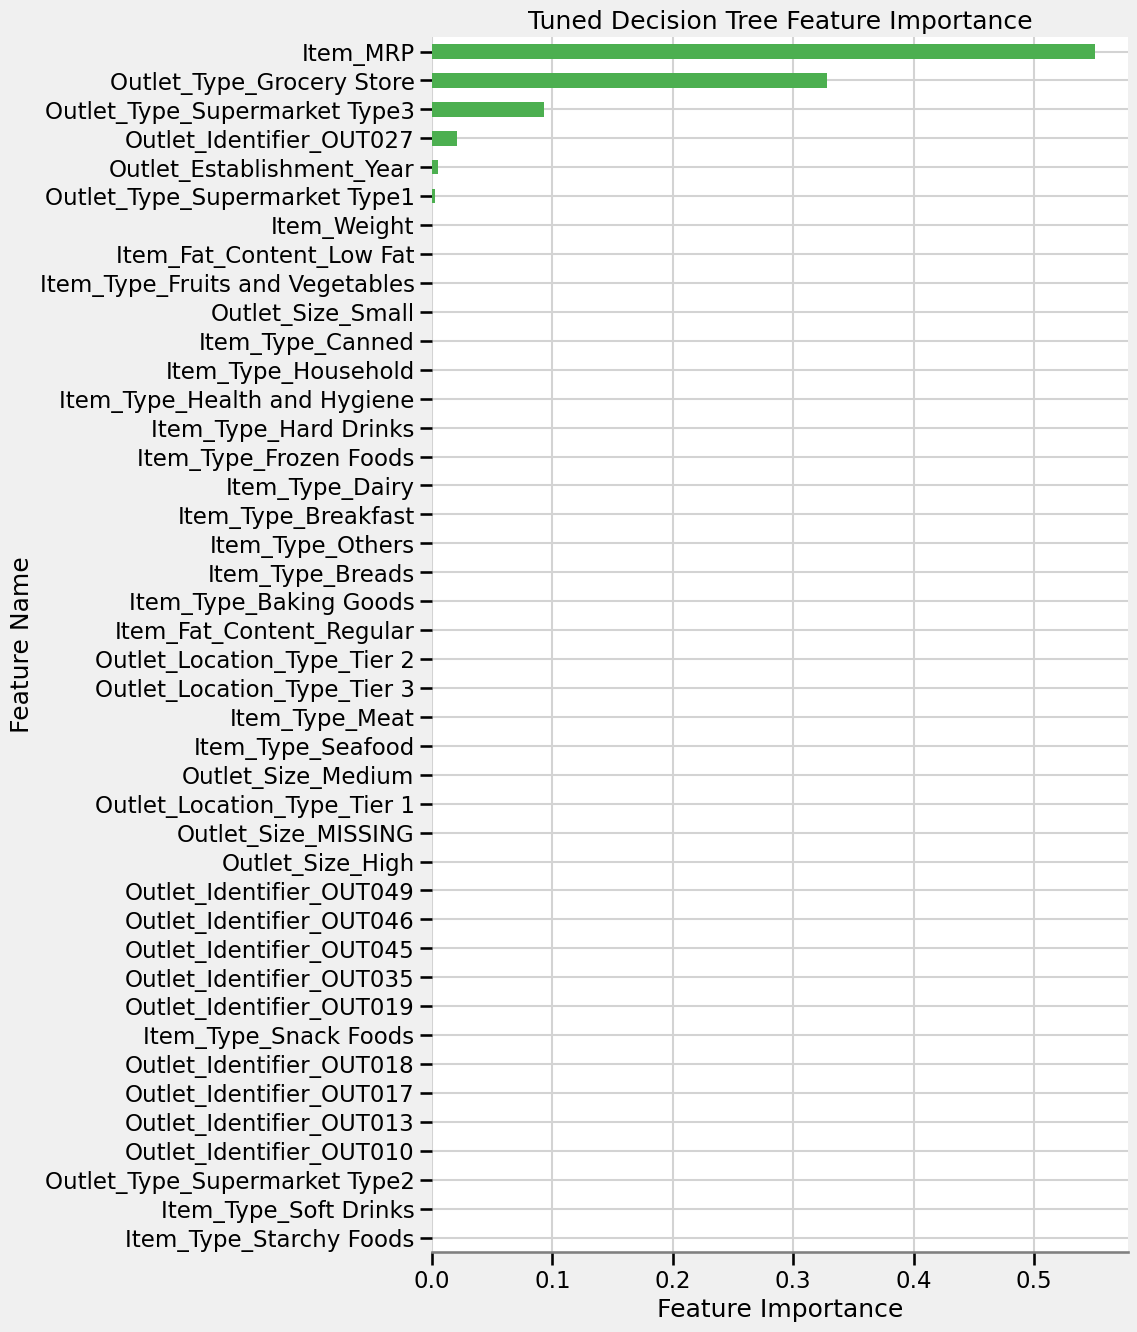
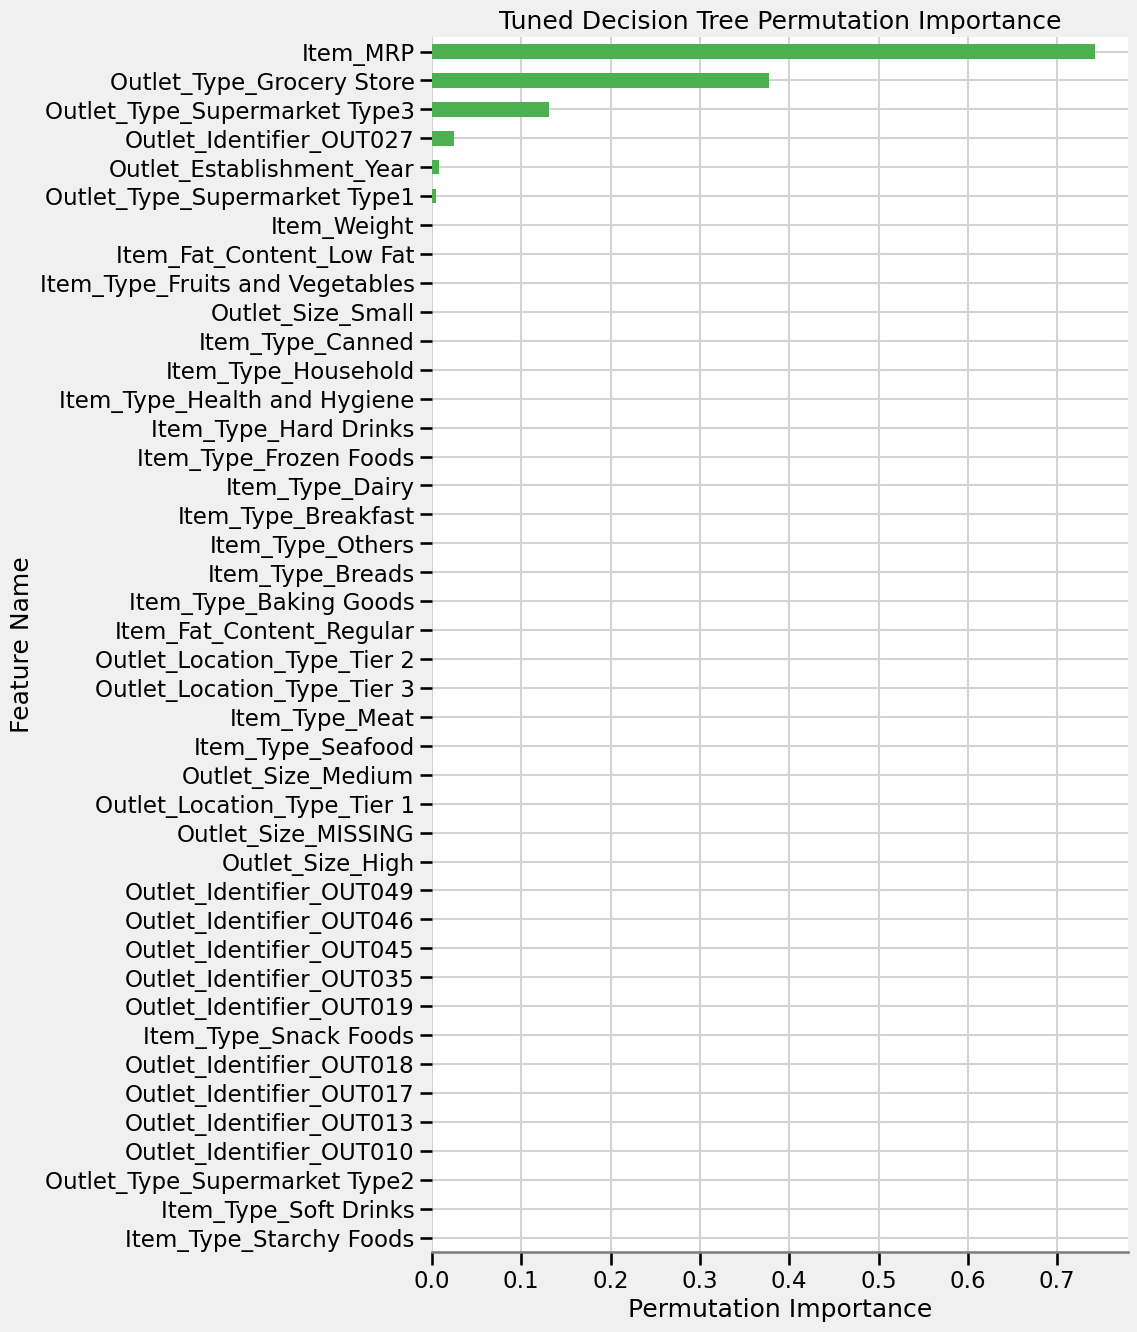

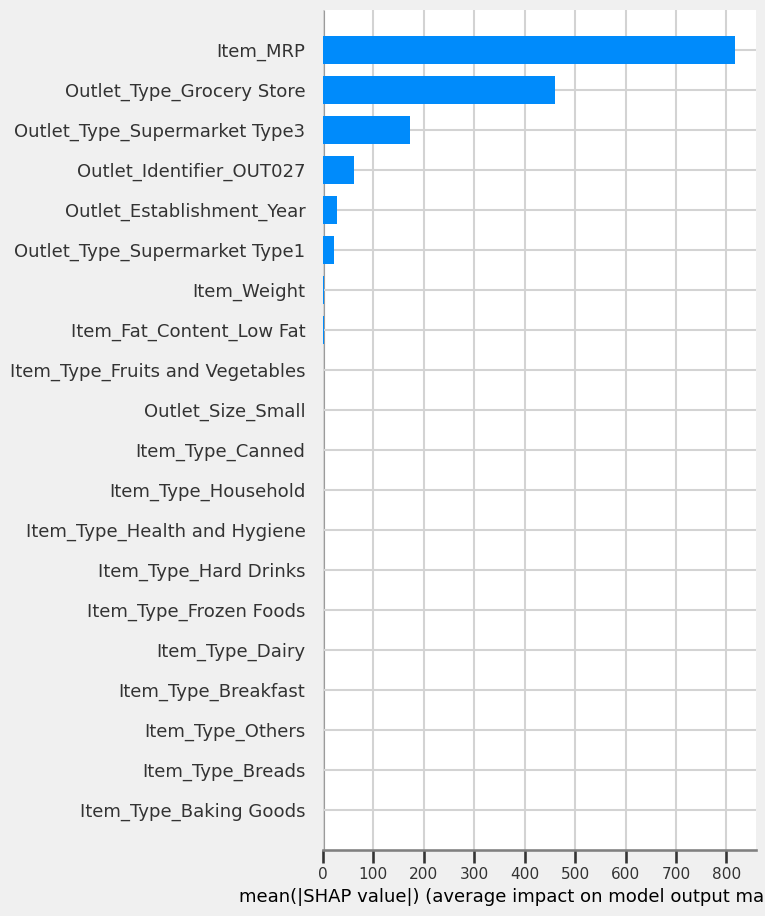

In [13]:
# Plot SHAP summary bar plot
shap.summary_plot(shap_values,features= X_shap, plot_type='bar')



## Comparing SHAP Values with Feature and Permutation Importance

- Reviewing the three plots above, the top three features are consistent across all figures. However, the SHAP average impact of features on the models' predictions slightly differs from the values obtained using the decision tree's built-in feature importance.
- Both SHAP and permutation importance assign slightly less value to Outlet_Type_Grocery_Store, suggesting that the built-in method may have overestimated the importance of this feature in predictions.
- Similarly, the built-in feature importance method may have underestimated the significance of Outlet_Type_Supermarket_Type_3, as it was given slightly higher importance in both the permutation and SHAP summaries

## SHAP Summary

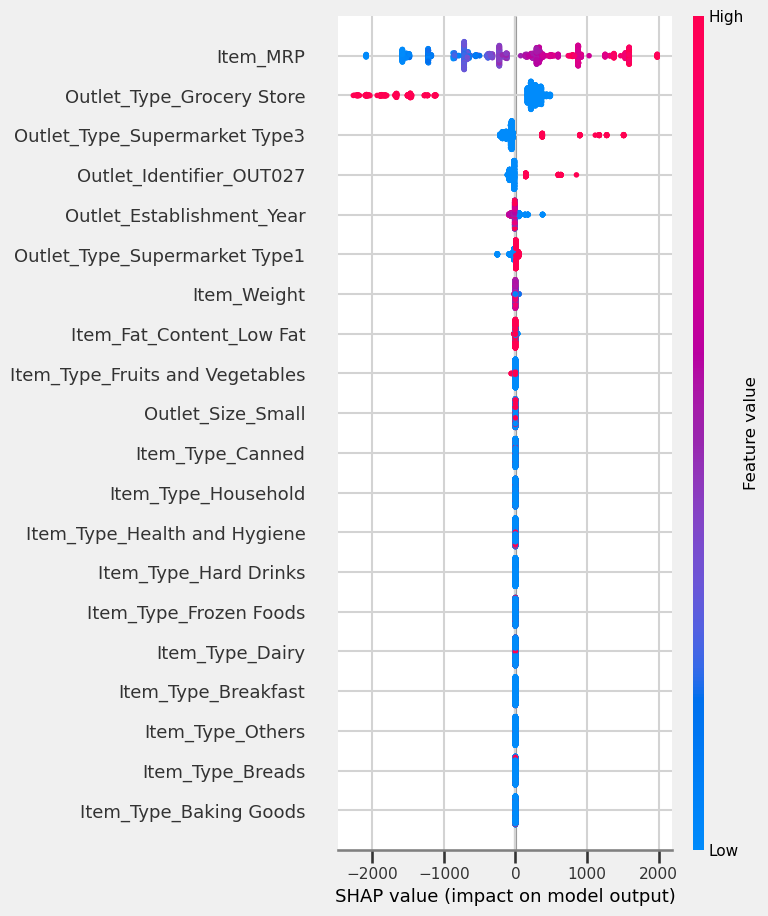

In [14]:
# Plot SHAP summary dot plot
shap.summary_plot(shap_values,X_shap)



- Item MRP had the most significant impact on our model's predictions. We observe that as the Item MRP value increases, the model is more inclined to predict higher Item Sales.

- For outlets categorized as 'Grocery Store,' our model is more likely to predict lower Item Sales. In our model, Grocery stores have a negative impact on the predicted target.

- Stores classified as 'Supermarket Type 3' tend to have a positive impact on the model's predictions for our target. Therefore, for stores in this category, predicted total item sales are more likely to be higher.

# Local Explanations

- Select at least 2 example rows based on the insights gained from your previous core assignments this week. 

- Explain why you selected the examples that you did.
    - If you're having trouble thinking of which type of examples to select, try selecting a store that had low sales ( one of the lowest values for your target) and one with high sales (the highest values for your target).

- For each example, produce :
    - A Lime tabular explanation
        - Interpret what features most heavily influenced the predictions, according to LIME.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: You will need to take a screenshot to save the lime explanation.
    - An individual Force Plot
        - Interpret what features most heavily influenced the predictions, according to SHAP.
        - Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README). Note: You will need to take a screenshot to save the individual force plot.

## Item with Highest MRP

**Examining the item with the highest Maximum Retail Price (MRP) is of particular interest because MRP exhibits a distinct positive correlation with total item sales. In the context of our local explanations, we will delve deeper into this specific example to gain a better understanding of how the highest-priced item contributes to our overall understanding of the sales dynamics**

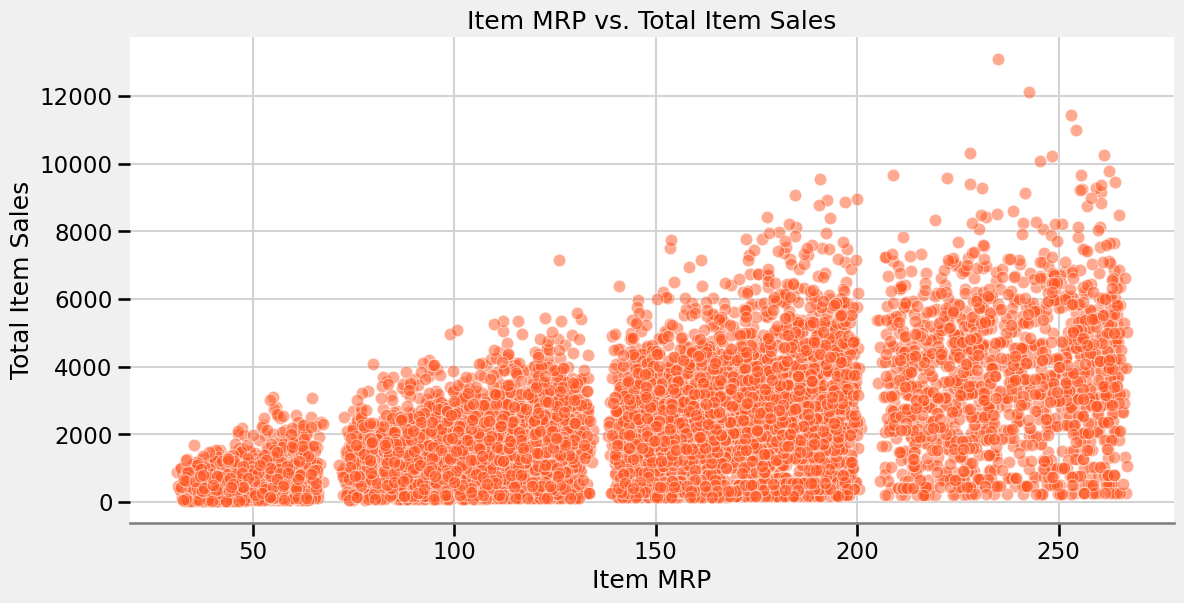

In [15]:
# Reset Index
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.describe()




Item_Weight     Item_MRP  Outlet_Establishment_Year  \
count  1000.000000  1000.000000                1000.000000   
mean     12.722205   137.280989                1997.862000   
std       4.343643    61.793751                   8.243113   
min       4.615000    31.290000                1985.000000   
25%       8.971250    90.092200                1987.000000   
50%      12.822634   136.589000                1999.000000   
75%      16.025000   182.386450                2004.000000   
max      21.350000   266.188400                2009.000000   

       Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
count               1000.000000               1000.000000   
mean                   0.653000                  0.347000   
std                    0.476254                  0.476254   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    1.000000                  0.000000   
75%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
count             1000.000000       1000.000000          1000.000000   
mean                 0.066000          0.037000             0.011000   
std                  0.248406          0.188856             0.104355   
min                  0.000000          0.000000             0.000000   
25%                  0.000000          0.000000             0.000000   
50%                  0.000000          0.000000             0.000000   
75%                  0.000000          0.000000             0.000000   
max                  1.000000          1.000000             1.000000   

       Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
count       1000.000000      1000.000000               1000.0000   
mean           0.071000         0.068000                  0.1020   
std            0.256953         0.251872                  0.3028   
min            0.000000         0.000000                  0.0000   
25%            0.000000         0.000000                  0.0000   
50%            0.000000         0.000000                  0.0000   
75%            0.000000         0.000000                  0.0000   
max            1.000000         1.000000                  1.0000   

       Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
count                       1000.00000            1000.000000   
mean                           0.18000               0.024000   
std                            0.38438               0.153126   
min                            0.00000               0.000000   
25%                            0.00000               0.000000   
50%                            0.00000               0.000000   
75%                            0.00000               0.000000   
max                            1.00000               1.000000   

       Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
count                   1000.000000          1000.000000     1000.000000   
mean                       0.070000             0.099000        0.052000   
std                        0.255275             0.298811        0.222138   
min                        0.000000             0.000000        0.000000   
25%                        0.000000             0.000000        0.000000   
50%                        0.000000             0.000000        0.000000   
75%                        0.000000             0.000000        0.000000   
max                        1.000000             1.000000        1.000000   

       Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
count       1000.000000        1000.000000             1000.00000   
mean           0.015000           0.005000                0.12700   
std            0.121613           0.070569                0.33314   
min            0.000000           0.000000                0.00000   
25%            0.000

In [16]:
# Find the index of the row with the maximum value in y_test
max_MRP_index = X_shap_local['Item_MRP'].idxmax()

# Print the index
print("Index of the row with the highest MRP:", max_MRP_index)

Index of the row with the highest MRP: 945


In [17]:
# checking the feature values for selected example
X_shap_local.iloc[max_MRP_index]

Item_Weight                           6.4650
Item_MRP                            266.1884
Outlet_Establishment_Year          1987.0000
Item_Fat_Content_Low Fat              1.0000
Item_Fat_Content_Regular              0.0000
Item_Type_Baking Goods                0.0000
Item_Type_Breads                      0.0000
Item_Type_Breakfast                   0.0000
Item_Type_Canned                      1.0000
Item_Type_Dairy                       0.0000
Item_Type_Frozen Foods                0.0000
Item_Type_Fruits and Vegetables       0.0000
Item_Type_Hard Drinks                 0.0000
Item_Type_Health and Hygiene          0.0000
Item_Type_Household                   0.0000
Item_Type_Meat                        0.0000
Item_Type_Others                      0.0000
Item_Type_Seafood                     0.0000
Item_Type_Snack Foods                 0.0000
Item_Type_Soft Drinks                 0.0000
Item_Type_Starchy Foods               0.0000
Outlet_Identifier_OUT010              0.0000
Outlet_Ide

**Item with index 945 has:**

- Has an MRP of 266.18
- Is a Low Fat food
- Canned item type
- Sold at Outlet 13
    - Outlet established in 1987
    - Classified as Supermarket Type 1
    - Location Type of Tier 3
    - High Outlet Size

In [18]:
# View actual Item_Outlet_Sales for max_MRP_index
y_shap_local.iloc[max_MRP_index]

5299.768

In [19]:
## plotting example force plot for item with highest Item_MRP
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[max_MRP_index].values,
               features = X_shap_local.iloc[max_MRP_index])

In [20]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names= X_shap_local.columns,
                                      mode='regression')

lime_explainer




In [21]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[max_MRP_index],
                                      loaded_model.predict)
exp.show_in_notebook();



#### Example 1: MRP Force Plot & Lime Explanations 

- SHAPs force plot predicts a base value of 2154 for this item.
    - The highest magnitude contibution came from Item MRP which positively impacted the sales prediction by the model.  
    - Outlet Type Grocey store value of False was the second greatest positive impact on the target value.  
    - The greatest negative impact on sales was the result of the outlet NOT being categorized as Supermarket Type 3 which penalized target value. 
    

- Limes explanations for this instance reflects that if an item has an MRP greater than 182.39, this will push the predicted value in a positive direction. 
    - Grocery Store categorization of false increased the sales prediction by 2008 rupees.
    - Item MRP being greater than 182.39 increased the models target by 1710 rupees.  
 

## Outlet Type = Grocery Store

**Outlets categorized as 'Grocery Store' tend to have a negative influence on our target variable, our second local explanation example will isolate and analyze an instance related to items sold in grocery stores.**

In [22]:
filt_grocery_yes = X_shap_local['Outlet_Type_Grocery Store']==True
len(X_shap_local[filt_grocery_yes])

136

In [23]:
# Describe grocery store examples
X_shap_local[filt_grocery_yes].describe()

Item_Weight    Item_MRP  Outlet_Establishment_Year  \
count   136.000000  136.000000                 136.000000   
mean     12.838442  128.242197                1992.264706   
std       3.506801   57.245865                   6.478723   
min       4.880000   35.219000                1985.000000   
25%      12.037500   82.150650                1985.000000   
50%      12.822634  124.207200                1998.000000   
75%      13.850000  170.493500                1998.000000   
max      21.350000  254.604000                1998.000000   

       Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
count                136.000000                136.000000   
mean                   0.639706                  0.360294   
std                    0.481861                  0.481861   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    1.000000                  0.000000   
75%                    1.000000                  1.000000   
max                    1.000000                  1.000000   

       Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
count              136.000000             136.0           136.000000   
mean                 0.066176               0.0             0.014706   
std                  0.249509               0.0             0.120818   
min                  0.000000               0.0             0.000000   
25%                  0.000000               0.0             0.000000   
50%                  0.000000               0.0             0.000000   
75%                  0.000000               0.0             0.000000   
max                  1.000000               0.0             1.000000   

       Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
count        136.000000       136.000000              136.000000   
mean           0.058824         0.073529                0.102941   
std            0.236164         0.261968                0.305005   
min            0.000000         0.000000                0.000000   
25%            0.000000         0.000000                0.000000   
50%            0.000000         0.000000                0.000000   
75%            0.000000         0.000000                0.000000   
max            1.000000         1.000000                1.000000   

       Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
count                       136.000000             136.000000   
mean                          0.169118               0.014706   
std                           0.376242               0.120818   
min                           0.000000               0.000000   
25%                           0.000000               0.000000   
50%                           0.000000               0.000000   
75%                           0.000000               0.000000   
max                           1.000000               1.000000   

       Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
count                    136.000000           136.000000      136.000000   
mean                       0.058824             0.088235        0.073529   
std                        0.236164             0.284685        0.261968   
min                        0.000000             0.000000        0.000000   
25%                        0.000000             0.000000        0.000000   
50%                        0.000000             0.000000        0.000000   
75%                        0.000000             0.000000        0.000000   
max                        1.000000             1.000000        1.000000   

       Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
count        136.000000         136.000000             136.000000   
mean           0.044118           0.007353               0.139706   
std            0.206116           0.085749               0.347963   
min            0.000000           0.000000               0.000000   
25%            0.000000      

**In order to refine our analysis and narrow down the set of items sold in outlets categorized as 'Grocery Store,' we will implement two additional filters. Firstly, we will consider outlets established in 1985, which represents the oldest establishments within our dataset. Secondly, we will incorporate a filter for the item with the highest retail price. By employing these dual filters, our objective is to create a more focused subset of data that can offer us deeper insights into the sales dynamics specific to 'Grocery Store' outlets, especially those that have been in operation for an extended period and involve high-value items.**

In [24]:
# Filter for OLDEST grocery store outlet type 
filt_year_yes = X_shap_local['Outlet_Establishment_Year']==1985
len(X_shap_local[filt_grocery_yes & filt_year_yes])

60

In [25]:
# Add filter for highest MRP
filt_MRP = X_shap_local['Item_MRP']==254.604000
len(X_shap_local[filt_grocery_yes & filt_year_yes & filt_MRP])

1

In [26]:
# Get index for single instance above
filt_item = X_shap_local[filt_grocery_yes & filt_year_yes & filt_MRP].index
filt_item

Index([398], dtype='int64')

In [27]:
# checking the feature values for selected example
X_shap_local.iloc[filt_item]

Item_Weight  Item_MRP  Outlet_Establishment_Year  \
398    12.822634   254.604                     1985.0   

     Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
398                       1.0                       0.0   

     Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
398                     0.0               0.0                  0.0   

     Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
398               0.0              0.0                     0.0   

     Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
398                              0.0                    0.0   

     Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
398                           0.0                  0.0             0.0   

     Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
398               1.0                0.0                    0.0   

     Item_Type_Soft Drinks  Item_Type_Starchy Foods  Outlet_Identifier_OUT010  \
398                    0.0                      0.0                       0.0   

     Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
398                       0.0                       0.0   

     Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
398                       0.0                       1.0   

     Outlet_Identifier_OUT027  Outlet_Identifier_OUT035  \
398                       0.0                       0.0   

     Outlet_Identifier_OUT045  Outlet_Identifier_OUT046  \
398                       0.0                       0.0   

     Outlet_Identifier_OUT049  Outlet_Size_High  Outlet_Size_MISSING  \
398                       0.0               0.0                  0.0   

     Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
398                 0.0                1.0                          1.0   

     Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
398                          0.0                          0.0   

     Outlet_Type_Grocery Store  Outlet_Type_Supermarket Type1  \
398                        1.0                            0.0   

     Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
398                            0.0                            0.0

**Item with index 398 has:**

- Weight of 12.8 ounces
- MRP of 254.60 Rupees
- Low-fat food
- Sold at Grocery Store number 19
    - Established in 1985
    - Small outlet size
    - Outlet type Tier-1


In [28]:
## plotting example force plot for item with highest Item_MRP
shap.force_plot(explainer.expected_value,
               shap_values=shap_values[filt_item].values,
               features = X_shap_local.iloc[filt_item])

In [29]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[398],
                                      loaded_model.predict)
exp.show_in_notebook();


#### Expample 2: Grocery Store Force Plot & Lime Explanations

- Our SHAP force plot predicts a base value of 2,154 for this item.  
    - The highest magnitude contribution was Outlet_Type_Grocery Store.  The outlet being categorized as this type of store resulted in the predicted sales being reduced significantly. 
    - Item MRP had the greatest positive contribution to item sales. 
    - Our final predicted sales for this item is estimated to be 604.37 rupees.
    
- Limes explanations for this instance reflects that if an item has an MRP greater than 182.39, this will push the predicted value in a positive direction. 
    - Grocery Store categorization was the largest factor in the predicted price, responsible for reducing the value by 2054 rupees.  